In [1]:
import numpy as np
import matplotlib.pyplot as plt
from auditory_cortex.neural_data import NormalizerCalculator
from auditory_cortex.neural_data import create_neural_metadata, create_neural_dataset

# Set up logging configuration
import sys
import logging
logging.basicConfig(
    level=logging.DEBUG,  # Capture all logs from DEBUG level and above
    handlers=[
        logging.StreamHandler(sys.stdout),  # Stream to the notebook's output
    ]
)

## means vs medians

### timit

In [2]:
dataset_name = 'ucsf'
metadata = create_neural_metadata(dataset_name)
sessions = metadata.get_all_available_sessions()

In [ ]:
bin_width = 50
mVocs = False
sess_wise_means = {}
sess_wise_medians = {}
sess_wise_stds = {}
for session in sessions:
    norm_obj = NormalizerCalculator(dataset_name, session)
    sess_norm_dist = norm_obj.get_normalizer_for_session(
        bin_width=bin_width, mVocs=mVocs
    )

    sess_wise_means[session] = np.mean(sess_norm_dist, axis=0)
    sess_wise_medians[session] = np.median(sess_norm_dist, axis=0)
    sess_wise_stds[session] = np.std(sess_norm_dist, axis=0)

In [4]:
total_channels = 0
for sess, means in sess_wise_means.items():
    # print(f"Session: {sess}, shape: {means.shape}" )
    total_channels += len(means)
total_channels

1718

In [7]:
all_means = [means for sess, means in sess_wise_means.items()]
all_means = np.concatenate(all_means, axis=0)

all_medians = [medians for sess, medians in sess_wise_medians.items()]
all_medians = np.concatenate(all_medians, axis=0)

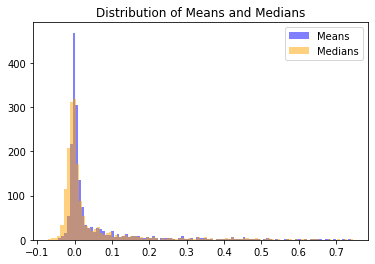

In [12]:
plt.hist(all_means, color='blue', alpha=0.5, label='Means', bins=100)
plt.hist(all_medians, color='orange', alpha=0.5, label='Medians', bins=100)
plt.title('Distribution of Means and Medians')
plt.legend()
plt.show()

In [13]:
from scipy.stats import wilcoxon

# Perform Wilcoxon signed-rank test
statistic, p_value = wilcoxon(all_means, all_medians)

print(f"Statistic: {statistic}")
print(f"P-value: {p_value}")


Statistic: 76889.0
P-value: 3.495880867188971e-226


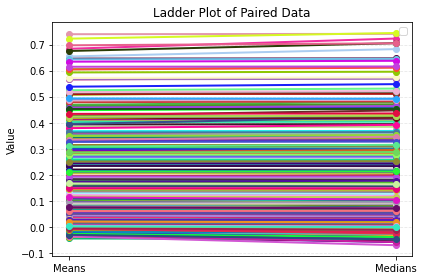

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Example paired data
x = all_means
y = all_medians

# Set random seed for reproducibility (optional)
np.random.seed(42)

# Plot ladder plot with random colors
plt.figure(figsize=(6, 4))
for i in range(len(x)):
    color = np.random.rand(3,)  # random RGB color
    plt.plot([0, 1], [x[i], y[i]], marker='o', color=color, linewidth=2)

# # Optional: show mean lines
# plt.plot([0, 1], [np.mean(x), np.mean(y)], color='black', linestyle='--', label='Mean')

# Formatting
plt.xticks([0, 1], ['Means', 'Medians'])
plt.ylabel('Value')
plt.title('Ladder Plot of Paired Data')
plt.grid(True, axis='y', linestyle='--', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


#### highly-tuned neurons

In [ ]:
norm_obj = NormalizerCalculator(dataset_name, session)

In [17]:
threshold_percentile = 90
null_dist = norm_obj.get_normalizer_null_dist_using_poisson(
                bin_width=bin_width, mVocs=mVocs,)
threshold = np.percentile(null_dist, threshold_percentile)  
print(f"Threshold for {threshold_percentile} percentile: {threshold}")

Threshold for 90 percentile: 0.07311907450200178


In [ ]:
highly_tuned_args = np.where(all_medians >= threshold)[0]
highly_tuned_medians = all_medians[highly_tuned_args]
highly_tuned_means = all_means[highly_tuned_args]

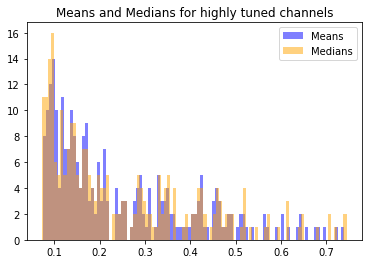

In [28]:
plt.hist(highly_tuned_means, color='blue', alpha=0.5, label='Means', bins=100)
plt.hist(highly_tuned_medians, color='orange', alpha=0.5, label='Medians', bins=100)
plt.title('Means and Medians for highly tuned channels')
plt.legend()
plt.show()

In [29]:
from scipy.stats import wilcoxon

# Perform Wilcoxon signed-rank test
statistic, p_value = wilcoxon(highly_tuned_means, highly_tuned_medians)

print(f"Statistic: {statistic}")
print(f"P-value: {p_value}")

Statistic: 15471.0
P-value: 0.068908854510549


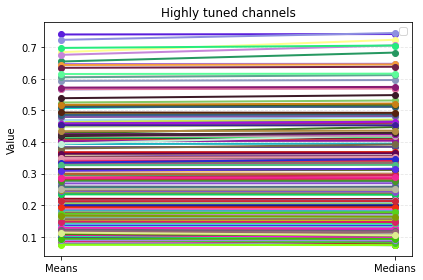

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Example paired data
x = highly_tuned_means
y = highly_tuned_medians

# Set random seed for reproducibility (optional)
np.random.seed(42)

# Plot ladder plot with random colors
plt.figure(figsize=(6, 4))
for i in range(len(x)):
    color = np.random.rand(3,)  # random RGB color
    plt.plot([0, 1], [x[i], y[i]], marker='o', color=color, linewidth=2)

# # Optional: show mean lines
# plt.plot([0, 1], [np.mean(x), np.mean(y)], color='black', linestyle='--', label='Mean')

# Formatting
plt.xticks([0, 1], ['Means', 'Medians'])
plt.ylabel('Value')
plt.title('Highly tuned channels')
plt.grid(True, axis='y', linestyle='--', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [30]:
highly_tuned_args = np.where(all_means >= threshold)[0]
highly_tuned_args.shape

(274,)

### mVocs

In [32]:
dataset_name = 'ucsf'
metadata = create_neural_metadata(dataset_name)
sessions = metadata.get_all_available_sessions()

In [ ]:
bin_width = 50
mVocs = True
sess_wise_means = {}
sess_wise_medians = {}
sess_wise_stds = {}
for session in sessions:
    norm_obj = NormalizerCalculator(dataset_name, session)
    sess_norm_dist = norm_obj.get_normalizer_for_session(
        bin_width=bin_width, mVocs=mVocs
    )

    sess_wise_means[session] = np.mean(sess_norm_dist, axis=0)
    sess_wise_medians[session] = np.median(sess_norm_dist, axis=0)
    sess_wise_stds[session] = np.std(sess_norm_dist, axis=0)

In [34]:
total_channels = 0
for sess, means in sess_wise_means.items():
    # print(f"Session: {sess}, shape: {means.shape}" )
    total_channels += len(means)
total_channels

1718

In [35]:
all_means = [means for sess, means in sess_wise_means.items()]
all_means = np.concatenate(all_means, axis=0)

all_medians = [medians for sess, medians in sess_wise_medians.items()]
all_medians = np.concatenate(all_medians, axis=0)

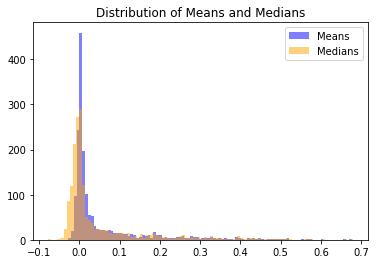

In [36]:
plt.hist(all_means, color='blue', alpha=0.5, label='Means', bins=100)
plt.hist(all_medians, color='orange', alpha=0.5, label='Medians', bins=100)
plt.title('Distribution of Means and Medians')
plt.legend()
plt.show()

In [37]:
from scipy.stats import wilcoxon

# Perform Wilcoxon signed-rank test
statistic, p_value = wilcoxon(all_means, all_medians)

print(f"Statistic: {statistic}")
print(f"P-value: {p_value}")

Statistic: 36742.0
P-value: 7.280695780323757e-233


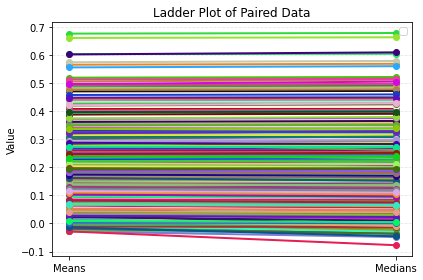

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Example paired data
x = all_means
y = all_medians

# Set random seed for reproducibility (optional)
np.random.seed(42)

# Plot ladder plot with random colors
plt.figure(figsize=(6, 4))
for i in range(len(x)):
    color = np.random.rand(3,)  # random RGB color
    plt.plot([0, 1], [x[i], y[i]], marker='o', color=color, linewidth=2)

# # Optional: show mean lines
# plt.plot([0, 1], [np.mean(x), np.mean(y)], color='black', linestyle='--', label='Mean')

# Formatting
plt.xticks([0, 1], ['Means', 'Medians'])
plt.ylabel('Value')
plt.title('Ladder Plot of Paired Data')
plt.grid(True, axis='y', linestyle='--', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


#### highly-tuned neurons

In [39]:
threshold_percentile = 90
null_dist = norm_obj.get_normalizer_null_dist_using_poisson(
                bin_width=bin_width, mVocs=mVocs,)
threshold = np.percentile(null_dist, threshold_percentile)  
print(f"Threshold for {threshold_percentile} percentile: {threshold}")

Threshold for 90 percentile: 0.08937104194148332


In [40]:
highly_tuned_args = np.where(all_medians >= threshold)[0]
print("Highly tuned channels:", highly_tuned_args.shape[0])
highly_tuned_medians = all_medians[highly_tuned_args]
highly_tuned_means = all_means[highly_tuned_args]

Highly tuned channels: 312


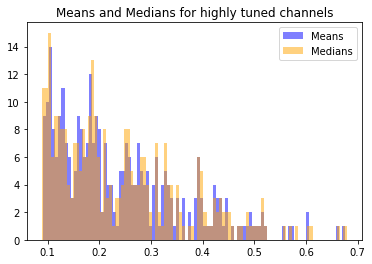

In [41]:
plt.hist(highly_tuned_means, color='blue', alpha=0.5, label='Means', bins=100)
plt.hist(highly_tuned_medians, color='orange', alpha=0.5, label='Medians', bins=100)
plt.title('Means and Medians for highly tuned channels')
plt.legend()
plt.show()

In [42]:
from scipy.stats import wilcoxon

# Perform Wilcoxon signed-rank test
statistic, p_value = wilcoxon(highly_tuned_means, highly_tuned_medians)

print(f"Statistic: {statistic}")
print(f"P-value: {p_value}")

Statistic: 17749.0
P-value: 2.922499979827881e-05


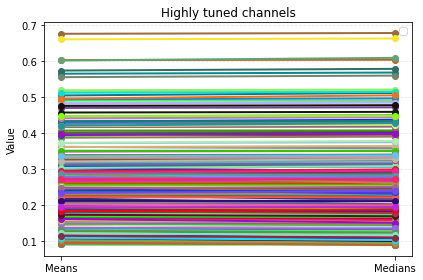

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# Example paired data
x = highly_tuned_means
y = highly_tuned_medians

# Set random seed for reproducibility (optional)
np.random.seed(42)

# Plot ladder plot with random colors
plt.figure(figsize=(6, 4))
for i in range(len(x)):
    color = np.random.rand(3,)  # random RGB color
    plt.plot([0, 1], [x[i], y[i]], marker='o', color=color, linewidth=2)

# # Optional: show mean lines
# plt.plot([0, 1], [np.mean(x), np.mean(y)], color='black', linestyle='--', label='Mean')

# Formatting
plt.xticks([0, 1], ['Means', 'Medians'])
plt.ylabel('Value')
plt.title('Highly tuned channels')
plt.grid(True, axis='y', linestyle='--', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [44]:
highly_tuned_args = np.where(all_means >= threshold)[0]
highly_tuned_args.shape

(325,)